<a href="https://colab.research.google.com/github/Tony5t4rk/ML-2021-Spring/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 3 - Convolutional Neural Network**

作者: 刘阳

学习笔记：[機器學習2021 学习笔记-CNN & Self-Attention](https://www.wolai.com/tony5t4rk/jFYeVKmHKnfwJyLEK18Gbh?theme=light)

本HW01在[样例代码](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW03/HW03.ipynb#scrollTo=VHpJocsDr6iA)的基础上进行修改。


# Mount into Google Drive & Show GPU

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab/ML 2021 Spring/HW03'
!nvidia-smi

Mounted at /content/drive
/content/drive/MyDrive/Colab/ML 2021 Spring/HW03
Fri May  7 09:27:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
             

# Download Data from Google Drive

In [2]:
# !gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip
# !unzip -q food-11.zip
!apt-get -qq install -y tree
!tree -L 2

train_path = 'food-11/training'
val_path = 'food-11/validation'
test_path = 'food-11/testing'

Selecting previously unselected package tree.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
.
├── CNN(bak).ipynb
├── CNN.ipynb
├── food-11
│   ├── testing
│   ├── training
│   └── validation
├── food-11.pred.csv
├── food-11.zip
├── Learning curve of CNN Model.svg
├── Learning curve of ResNet18.svg
└── models
    └── model.pth

5 directories, 7 files


# Import Package

In [3]:
import numpy as np
import os
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# set a random seed for reproducibility
my_seed = 42096
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(my_seed)
torch.manual_seed(my_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(my_seed)

# Plot Utility

In [4]:
def plot_learning_curve(loss_record, title=''):
    n_epochs = len(loss_record['train'])
    x_1 = range(n_epochs)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_1, loss_record['val'], c='tab:cyan', label='val')
    plt.ylim(0.0, 5.)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.savefig('Learning curve of {}.svg'.format(title))
    plt.show()

# Hyper-Parameters

In [5]:
os.makedirs('models', exist_ok=True)

config = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'n_epochs': 80,
    'batch_size': 128,
    'optim_hparams': {
        'lr': 0.0003,
        'weight_decay': 1e-5
    },
    'do_semi': False,
    'early_stop': False,
    'early_stop_epochs': 8,
    'model_path': 'models/model.pth',
    'pred_file': 'food-11.pred.csv'
}

print(f'device: {config["device"]}')

device: cuda


# Data Process

## Image Transform

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

## Dataset

In [7]:
train_dataset = DatasetFolder('food-11/training/labeled', loader=lambda x: Image.open(x), extensions='jpg', transform=train_transform)
unlabeled_dataset = DatasetFolder('food-11/training/unlabeled', loader=lambda x: Image.open(x), extensions='jpg', transform=train_transform)
val_dataset = DatasetFolder('food-11/validation', loader=lambda x: Image.open(x), extensions='jpg', transform=test_transform)
test_dataset = DatasetFolder('food-11/testing', loader=lambda x: Image.open(x), extensions="jpg", transform=test_transform)

## DataLoader

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

# Model

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
        )
        self.fc = nn.Sequential(
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )
    
    def forward(self, x):
        x = self.cnn(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

model = Net().to(config['device'])
# model = torchvision.models.resnet18(pretrained=False).to(config['device'])

# Training

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['optim_hparams']['lr'], weight_decay=config['optim_hparams']['weight_decay'])

loss_record = {'train': [], 'val': []}

if config['early_stop']:
    min_val_loss = float('inf')
    early_stop_cnt = 0

epoch = 0
while epoch < config['n_epochs']:
    # TODO: semi
    if config['do_semi']:
        pass

    model.train()
    train_loss = []
    for x, y in train_dataloader:
        x, y = x.to(config['device']), y.to(config['device'])
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        # grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()
        train_loss.append(loss.item())
    train_loss = sum(train_loss) / len(train_loss)
    loss_record['train'].append(train_loss)

    model.eval()
    val_loss = []
    for x, y in val_dataloader:
        x, y = x.to(config['device']), y.to(config['device'])
        with torch.no_grad():
            logits = model(x)
        loss = criterion(logits, y)
        val_loss.append(loss)
    val_loss = sum(val_loss) / len(val_loss)
    loss_record['val'].append(val_loss)

    print(f'[ Epoch {epoch + 1:03d}|{config["n_epochs"]:03d} ] Train Loss: {train_loss:.5f}   Valid Loss: {val_loss:.5f}')

    if config['early_stop']:
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model, config['model_path'])
            print(f'Early Stop Saving Model on Epoch {epoch + 1:03d}({config["n_epochs"]:03d})')
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
    else:
        torch.save(model, config['model_path'])
    
    epoch += 1

    if config['early_stop'] and early_stop_cnt > config['early_stop_epochs']:
        break

print(f'Finish Train After {epoch} Epochs')

[ Epoch 001|080 ] Train Loss: 2.36659   Valid Loss: 2.42304
[ Epoch 002|080 ] Train Loss: 1.99115   Valid Loss: 2.19757
[ Epoch 003|080 ] Train Loss: 1.86324   Valid Loss: 1.83486
[ Epoch 004|080 ] Train Loss: 1.75775   Valid Loss: 1.84532
[ Epoch 005|080 ] Train Loss: 1.60631   Valid Loss: 1.74451
[ Epoch 006|080 ] Train Loss: 1.52127   Valid Loss: 1.68906
[ Epoch 007|080 ] Train Loss: 1.41196   Valid Loss: 1.64622
[ Epoch 008|080 ] Train Loss: 1.37617   Valid Loss: 1.70558
[ Epoch 009|080 ] Train Loss: 1.24090   Valid Loss: 1.78493
[ Epoch 010|080 ] Train Loss: 1.14686   Valid Loss: 1.83236
[ Epoch 011|080 ] Train Loss: 1.20435   Valid Loss: 1.52793
[ Epoch 012|080 ] Train Loss: 1.08833   Valid Loss: 1.61104
[ Epoch 013|080 ] Train Loss: 0.94527   Valid Loss: 1.53070
[ Epoch 014|080 ] Train Loss: 0.88694   Valid Loss: 1.61583
[ Epoch 015|080 ] Train Loss: 0.80020   Valid Loss: 1.81634
[ Epoch 016|080 ] Train Loss: 0.83451   Valid Loss: 1.94353
[ Epoch 017|080 ] Train Loss: 0.79884   

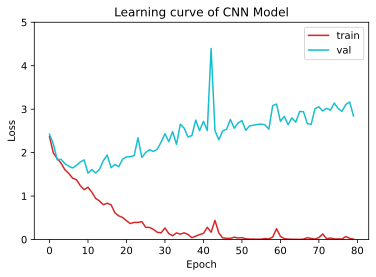

In [11]:
plot_learning_curve(loss_record, title='CNN Model')
# plot_learning_curve(loss_record, title='ResNet-18 Model')

# Testing

In [12]:
del model
model = torch.load(config['model_path']).to(config['device'])

In [13]:
model.eval()

preds = []
for x, _ in test_dataloader:
    x, _ = x.to(config['device']), _.to(config['device'])
    with torch.no_grad():
        logits = model(x)
    preds.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

In [14]:
print(f'Saving Result to {config["pred_file"]}')
with open(config['pred_file'], 'w') as fp:
    fp.write('Id,Category\n')
    for id, pred in enumerate(preds):
        fp.write(f'{id},{pred}\n')

Saving Result to food-11.pred.csv


# Result

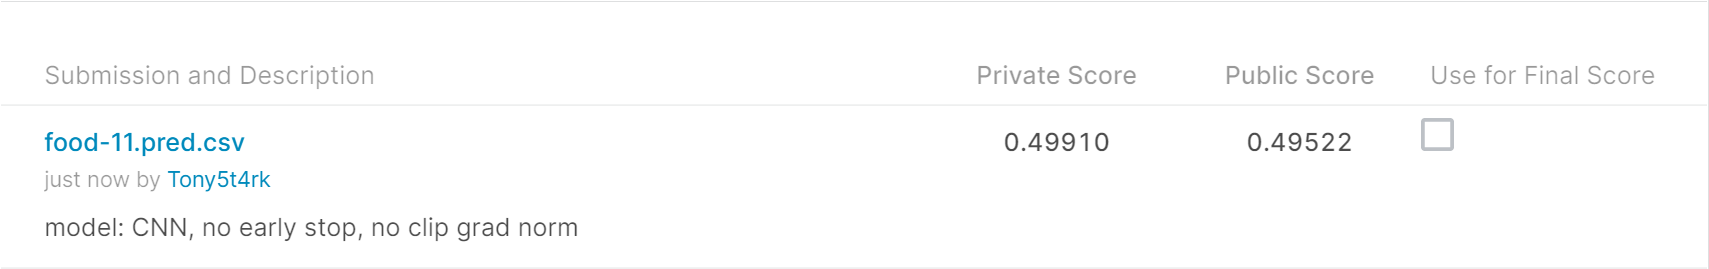